# Assignment 4

In this assignment, you will be using LSTM models on univariate and multivariate time series.

* [1. Introduction](#h1)  

* [2. Univariate time series: LSTM](#h2)  

* [3. Multivariate time series: LSTM](#h3)  
 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/My\ Drive/Colab\ Notebooks/hw4

/content/gdrive/My Drive/Colab Notebooks/hw4


## 1. Introduction <a name="h1"></a>

In this homework, we will model temporal trends on sales price of items from a grocery store. There are 50 items from 10 locations. We will first look at univariate temporal trends, which means that only one item from one location is picked. Then we will run a multivariate model to see whether more data can improve the prediction or not.    

In [ ]:
!pip install --upgrade statsmodels

In [ ]:
import matplotlib.pyplot as plt  
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error
import math

color = sns.color_palette()
sns.set_style('darkgrid')

# save me from using display function every time I have multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Download data from [GitHub](https://github.com/yuankaihuo/DL_course_hw/tree/master/Homework%202/data) and save them on your drive

In [ ]:
# load data
train_data = pd.read_csv("data/train.csv",parse_dates=['date'])

# focus on 1 store and 1 item
train_data = train_data[(train_data['store']==1) & (train_data['item']==1)] # 1460 by 4

train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
train_data['day'] = train_data['date'].dt.dayofyear
train_data['weekday'] = train_data['date'].dt.weekday

# make training and validation sets 
days = train_data.shape[0]
train_df = train_data.iloc[:(days - 90),:] # 3 years and 9 months
validate_df = train_data.iloc[-90:,:] # last 90 days

print("The training set has " + str(train_df.shape[0]) +" rows, and " + str(train_df.shape[1]) + " columns.")
print("The validation set has " + str(validate_df.shape[0]) +" rows, and " + str(validate_df.shape[1]) + " columns.")

The training set has 1370 rows, and 8 columns.
The validation set has 90 rows, and 8 columns.


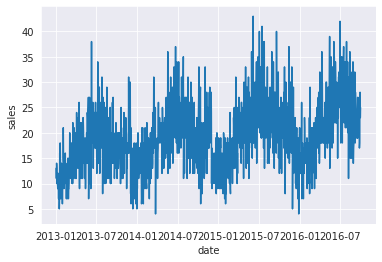

In [ ]:
# full temporal trend
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)
plt.show()

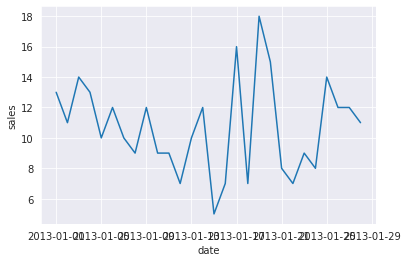

In [ ]:
# temporal trend of first 28 days
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])
plt.show()

### Seasonality decomposition

<Figure size 432x288 with 0 Axes>

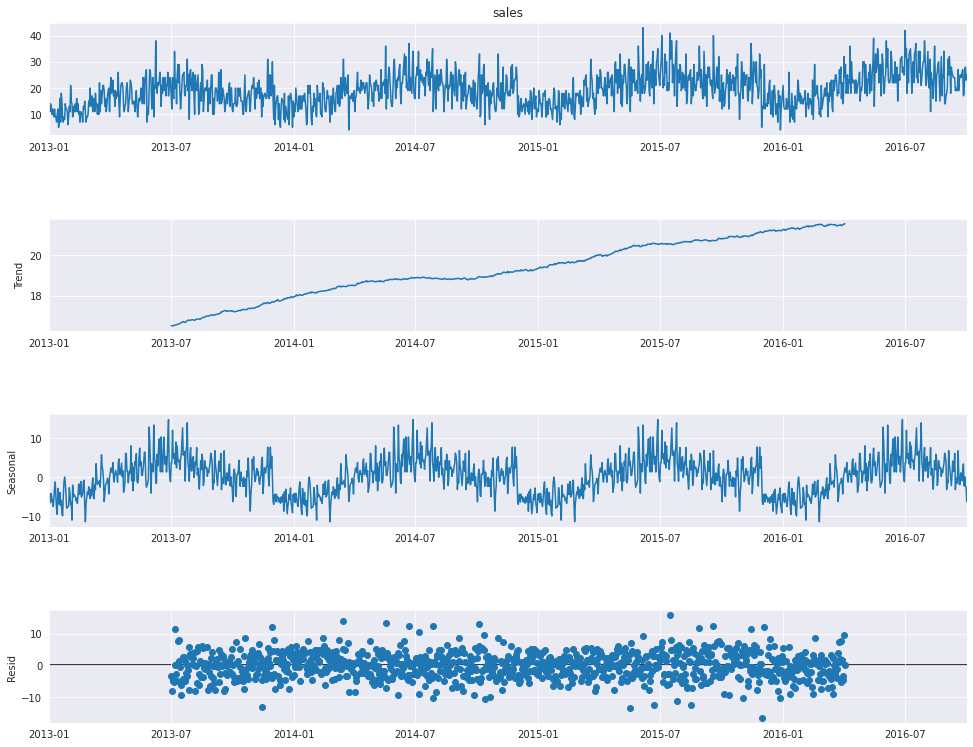

In [ ]:
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)
validate_df = validate_df.set_index('date')
validate_df['sales'] = validate_df['sales'].astype(float)

result = seasonal_decompose(train_df['sales'], model='additive',period=365)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15, 12)
plt.show()


## 2. Univariate time series: LSTM <a name="h2"></a>

Again, we use the item 1 from store 1 as an example to illustrate how LSTM works with one dimensional input.

In [ ]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size


The training data set has 3 years and 9 months data, and the validation data set has 3 months data.  

In [ ]:
# reading the input data
train_df = pd.read_csv('data/train.csv',parse_dates=['date'])
train_df = train_df[(train_df['store'] == 1) & (train_df['item'] == 1)]

all_train_data = train_df['sales'].values.astype(float)

train_data = all_train_data[:-90] # 3 years and 9 months
test_data = all_train_data[-90:] # last 90 days


First, let's scale the data

In [ ]:
# scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = scaler.fit_transform(test_data .reshape(-1, 1))
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

Set the training window to be 10 days. You can tune this parameter for better performance.  

In [ ]:
# moving window
train_window = 10

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
test_inout_seq = create_inout_sequences(test_data_normalized, train_window)


class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()

def model_train(epochs = 30):
    
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for i in range(1,epochs+1):
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        # validation
        with torch.no_grad():
            for seq, labels in test_inout_seq:
                y_test_pred = model(seq)
                test_loss = loss_function(y_test_pred.float(), labels)

        if i%5 == 0:
            print(f'Epoch {i} train loss: {single_loss.item():.4f} test loss: {test_loss.item():.4f}')

Train the model 

In [ ]:
model_train(epochs=15)

Epoch 5 train loss: 0.0032 test loss: 0.1113
Epoch 10 train loss: 0.0004 test loss: 0.0707
Epoch 15 train loss: 0.0051 test loss: 0.0994


Prediction in the validation set (next 90 days)

In [ ]:

fut_pred = 90

test_inputs = train_data_normalized[-train_window:].tolist()
# print(test_inputs)

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))


Plot prediction calibration

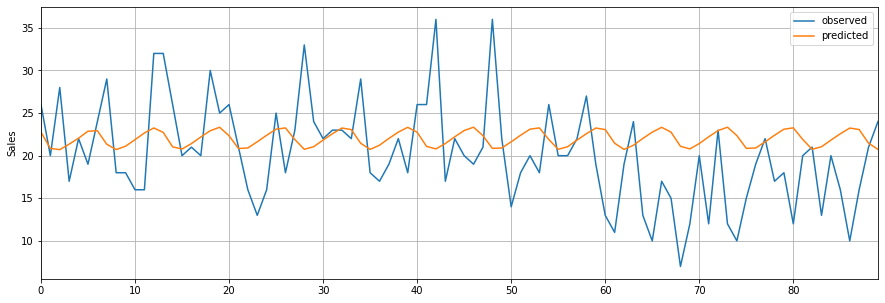

In [ ]:
# plot calibration
plt.ylabel('Sales')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(test_data,label="observed")
plt.plot(actual_predictions,label="predicted")
plt.legend()
plt.show()


Calculate prediction RMSE

In [ ]:
# rmse
math.sqrt(mean_squared_error(test_data,actual_predictions))

6.220954729510906

## 3. Multivariate time series: LSTM <a name="h3"></a>

In [ ]:
from numpy import array

Set training window 

In [ ]:
window = 45 # time window in model training

Prepare data

In [ ]:
train_df = pd.read_csv('data/train.csv',parse_dates=['date'])
train_df['sales'] = train_df['sales'].values.astype(float)

train_data = train_df[train_df['date']<'2016-10-02'] # 3 years and 9 months
test_data = train_df[train_df['date']>'2016-10-01'] # last 90 days


Reshape data to wide format

In [ ]:
def to_wide(data):

    data['id'] = 'store '+ data['store'].astype(str) + ', item ' + data['item'].astype(str)
    data = data.drop(['store','item'],axis=1)

    data_wide = data.pivot_table(index='date',
                                 columns='id',
                                 values='sales')
    return data_wide.values

train_wide = to_wide(train_data)
test_wide = to_wide(test_data)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Scale data

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_wide.reshape(-1, train_wide.shape[-1])).reshape(train_wide.shape)
test_data_normalized = scaler.fit_transform(test_wide.reshape(-1, test_wide.shape[-1])).reshape(test_wide.shape)

Get sequences of data

In [ ]:
def to_sequences(sequences,n_steps_in,n_steps_out):
    X, y = list(), list()

    for i in range(len(sequences)):

        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]

        X.append(seq_x)
        y.append(seq_y)

    return array(X), array(y)

train_X, train_y=to_sequences(train_data_normalized,window,1)
test_X, test_y=to_sequences(test_data_normalized,window,1)

train_X = torch.DoubleTensor(train_X) # 1340, window, 500
train_y = torch.DoubleTensor(train_y) # 1340, 1, 500
test_X = torch.DoubleTensor(test_X) # 60, window, 500
test_y = torch.DoubleTensor(test_y) # 60, 1, 500


Define multivariate LSTM model

In [ ]:

class LSTM(nn.Module):
    def __init__(self, input_size=500, hidden_layer_size=100, output_size=500):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,window,self.hidden_layer_size),
                            torch.zeros(1,window,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out)
        return predictions[:,0,:]


Define training function

In [ ]:

def model_train(epochs = 30):
    model = LSTM()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for i in range(1,epochs+1):

        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, window, model.hidden_layer_size),
                        torch.zeros(1, window, model.hidden_layer_size))

        y_pred = model(train_X.float())

        single_loss = loss_function(y_pred.float(), train_y.view(len(train_y),500).float())
        single_loss.backward()
        optimizer.step()

        # validation
        with torch.no_grad():
            y_test_pred = model(test_X.float())
            test_loss = loss_function(y_test_pred.float(), test_y.view(len(test_y),500).float())

        if i%5 == 0:
            print(f'Epoch {i} train loss: {single_loss.item():.4f} test loss: {test_loss.item():.4f}')
    return model


In [ ]:
model = model_train(epochs = 30)

Epoch 5 train loss: 0.1254 test loss: 0.2592
Epoch 10 train loss: 0.1079 test loss: 0.2625
Epoch 15 train loss: 0.0974 test loss: 0.2629
Epoch 20 train loss: 0.0922 test loss: 0.2640
Epoch 25 train loss: 0.0883 test loss: 0.2667
Epoch 30 train loss: 0.0836 test loss: 0.2668


Define prediction function

In [ ]:

def predict(fut_pred = 90):

    # prediction in the validation set

    test_inputs = train_X[-1][-window:]

    model.eval()

    for i in range(fut_pred):
        seq = torch.FloatTensor(test_inputs[-window:].float()).view(1,-1,500)
        with torch.no_grad():
            model.hidden = (torch.zeros(1, window, model.hidden_layer_size),
                            torch.zeros(1, window, model.hidden_layer_size))
            test_inputs = torch.cat((test_inputs.float(),model(seq)),0)

    actual_predictions = scaler.inverse_transform(np.array(test_inputs[window:] ))
    return actual_predictions


Get prediction

In [ ]:
actual_predictions = predict(fut_pred = 90)
pred_1_1 = actual_predictions[:,0]

observed = test_data['sales'][test_data['id']=='store 1, item 1'].values


Plot calibration

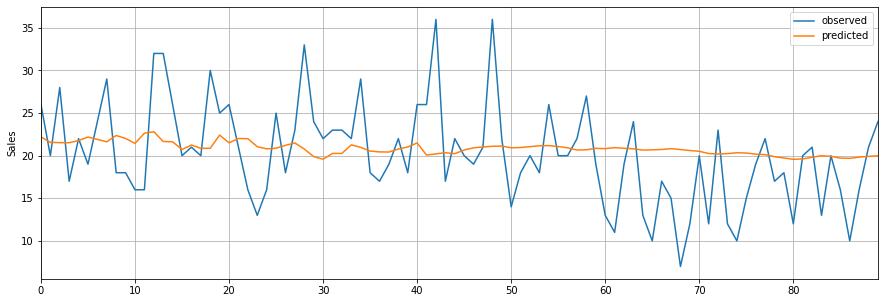

In [ ]:
plt.ylabel('Sales')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(observed,label="observed")
plt.plot(pred_1_1,label="predicted")
plt.legend()
plt.show()

Calculate prediction RMSE

In [ ]:

# rmse
math.sqrt(mean_squared_error(pred_1_1,observed)) 


5.676482608873295